<a href="https://colab.research.google.com/github/FelixEbenezer/segmentation_images/blob/main/Segmenta%C3%A7%C3%A3o_de_Imagens_com_Python_de_A_%C3%A0_Z_Segmenta%C3%A7%C3%A3o_Sem%C3%A2ntica_M%C3%A9dicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Imagens com Python de A à Z: Segmentação Semântica - Imagens médicas

# Importação das bibliotecas

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
from glob import glob
from imageio import mimread
from google.colab.patches import cv2_imshow
tensorflow.__version__

'2.8.0'

In [ ]:
seed = 42  
np.random.seed = seed  
random.seed = seed
tensorflow.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Carregamento da base de dados

In [ ]:
!cp /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/datasets/drive_dataset.zip /content/

In [ ]:
!unzip drive_dataset.zip -d /content/

Archive:  drive_dataset.zip
 extracting: /content/drive_dataset/test.zip  
 extracting: /content/drive_dataset/training.zip  


In [ ]:
!unzip drive_dataset/training.zip -d /content/drive_dataset/
!unzip drive_dataset/test.zip -d /content/drive_dataset/

Archive:  drive_dataset/training.zip
   creating: /content/drive_dataset/training/1st_manual/
 extracting: /content/drive_dataset/training/1st_manual/21_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/22_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/23_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/24_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/25_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/26_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/27_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/28_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/29_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/30_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/31_manual1.gif  
 extracting: /content/drive_dataset/training/1st_manual/32_manual1.gif  
 extracting: /content/drive_da

In [ ]:
def carregar_dataset(caminho):
  X_train = sorted(glob(os.path.join(caminho, "training", "images", "*.tif")))
  y_train = sorted(glob(os.path.join(caminho, "training", "1st_manual", "*.gif")))

  X_test = sorted(glob(os.path.join(caminho, "test", "images", "*.tif")))
  y_test = sorted(glob(os.path.join(caminho, "test", "1st_manual", "*.gif")))

  return (X_train, y_train), (X_test, y_test)

In [ ]:
path_dataset = "drive_dataset"
(X_train, y_train), (X_test, y_test) = carregar_dataset(path_dataset)

In [ ]:
len(X_train), len(y_train)

(20, 20)

In [ ]:
len(X_test), len(y_test)

(20, 20)

In [ ]:
img_altura = 512
img_largura = 512

# Data augmentation

- Albumentation: https://github.com/albumentations-team/albumentations

Usaremos 5 transformações para gerar novas imagens: 

* [HorizontalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.HorizontalFlip) - Espelha a imagem horizontalmente

* [VerticalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.VerticalFlip) - Espelha a imagem verticalmente

* [OpticalDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.OpticalDistortion) - Distorções ópticas, que imitam distorções causadas por lentes na fotografia ex: distorção do tipo barril e do tipo almofada 

* [ElasticTransform](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.ElasticTransform) - Distorções na estrutura da imagem, por exemplo aquele efeito de ondas/ondulações sobre a imagem

* [GridDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GridDistortion) - Distorções na grade (grid) da imagem, causando o efeito de variações na distribuição ao longo da imagem (como se a imagem vista de cima tivesse algumas "montanhas",onde algumas regiões estão mais "próximas" e outras mais distantes)


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [ ]:
criar_diretorio('dataset_final/train/images')
criar_diretorio('dataset_final/train/mask')

criar_diretorio('dataset_final/test/images')
criar_diretorio('dataset_final/test/mask')

In [ ]:
def novas_imagens(imagens, mascaras, dir_salvo, img_altura=512, img_largura=512, augmentation=True):
  for idx, (x, y) in tqdm(enumerate(zip(imagens, mascaras)), total = len(imagens)):
    nome = x.split('/')[-1].split('.')[0]
    #print(nome)

    x = cv2.imread(x)
    y = mimread(y)[0]

    if augmentation:
      aug = HorizontalFlip(p = 1.0)
      augmentation = aug(image = x, mask = y)
      x1 = augmentation['image']
      y1 = augmentation['mask']

      aug = VerticalFlip(p = 1.0)
      augmentation = aug(image = x, mask = y)
      x2 = augmentation['image']
      y2 = augmentation['mask']

      aug = OpticalDistortion(p = 1.0, distort_limit = 2, shift_limit=0.5)
      augmentation = aug(image = x, mask = y)
      x3 = augmentation['image']
      y3 = augmentation['mask']

      aug = ElasticTransform(p = 1.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
      augmentation = aug(image = x, mask = y)
      x4 = augmentation['image']
      y4 = augmentation['mask']

      aug = GridDistortion(p = 1.0)
      augmentation = aug(image = x, mask = y)
      x5 = augmentation['image']
      y5 = augmentation['mask']

      X = [x, x1, x2, x3, x4, x5]
      y = [y, y1, y2, y3, y4, y5]
    else:
      X = [x]
      y = [y]

    indice = 0
    for img, mask in zip(X, y):
      img = cv2.resize(img, (img_largura, img_altura))
      mask = cv2.resize(mask, (img_largura, img_altura))

      if len(X) == 1:
        tmp_img_nome = f"{nome}.png"
        tmp_mask_nome = f"{nome}.png"
      else:
        tmp_img_nome = f"{nome}_{indice}.png"
        tmp_mask_nome = f"{nome}_{indice}.png"

      path_imagem = os.path.join(dir_salvo, "images", tmp_img_nome)
      path_mascara = os.path.join(dir_salvo, "mask", tmp_mask_nome)

      cv2.imwrite(path_imagem, img)
      cv2.imwrite(path_mascara, mask)

      indice += 1

In [ ]:
novas_imagens(X_train, y_train, 'dataset_final/train/', augmentation=True)

100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


In [ ]:
novas_imagens(X_test, y_test, 'dataset_final/test/', augmentation=False)

100%|██████████| 20/20 [00:01<00:00, 13.20it/s]


In [ ]:
dir_geradas_train = 'dataset_final/train/'
imgs_geradas = [os.path.join(dir_geradas_train + 'images', f) for f in os.listdir(dir_geradas_train + 'images')]
masks_geradas = [os.path.join(dir_geradas_train + 'mask', f) for f in os.listdir(dir_geradas_train + 'mask')]

In [ ]:
len(imgs_geradas)

120

In [ ]:
len(masks_geradas)

120

In [ ]:
20 * 5 + 20

120

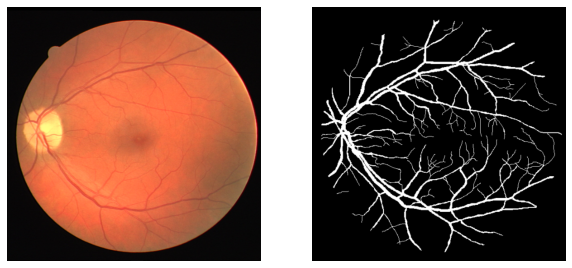

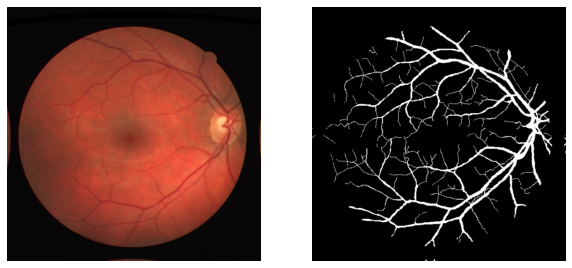

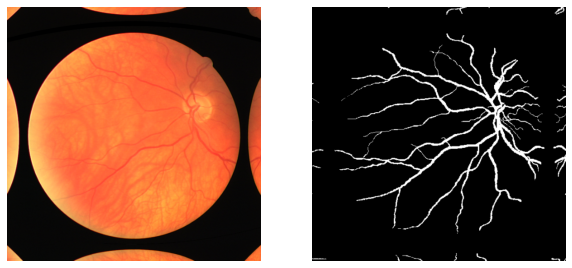

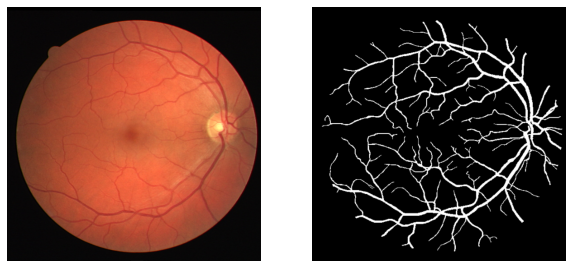

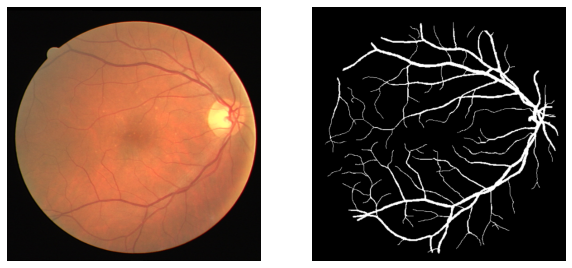

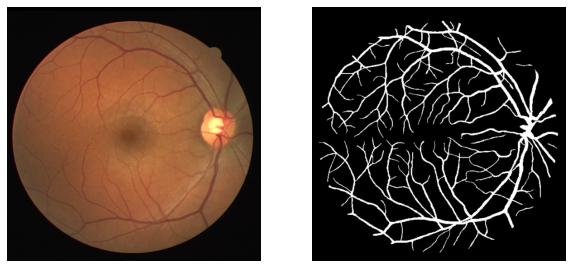

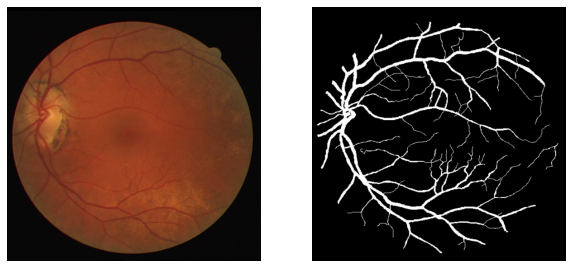

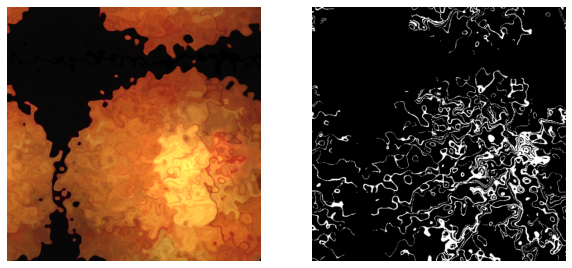

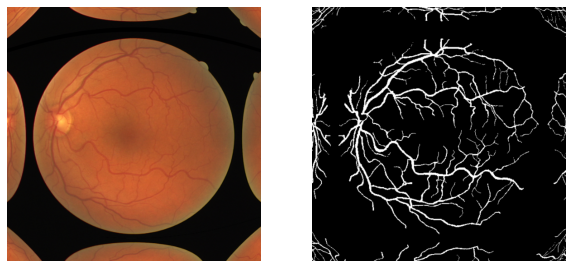

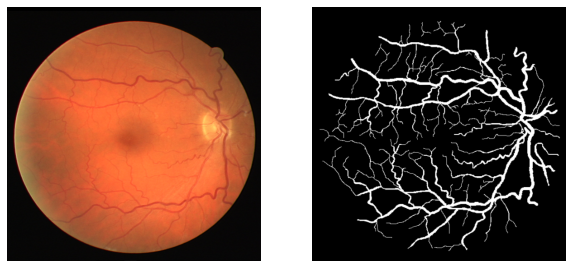

In [ ]:
for i in range(10):
  fig = plt.figure(figsize=(10,7))

  fig.add_subplot(1,2,1)
  img_teste = cv2.imread(imgs_geradas[i])
  plt.imshow(cv2.cvtColor(img_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  fig.add_subplot(1,2,2)
  mask_teste = cv2.imread(masks_geradas[i])
  plt.imshow(cv2.cvtColor(mask_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

# Construção da rede neural

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Recall, Precision

def bloco_conv(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    return x

def bloco_encoder(input, num_filters):
    x = bloco_conv(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  


def bloco_decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = bloco_conv(x, num_filters)
    return x 


def modelo_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = bloco_encoder(inputs, 64)
    s2, p2 = bloco_encoder(p1, 64*2) #128
    s3, p3 = bloco_encoder(p2, 64*4) #256
    s4, p4 = bloco_encoder(p3, 64*8) #512

    b1 = bloco_conv(p4, 64*16)  #1024

    d1 = bloco_decoder(b1, s4, 64*8) #512
    d2 = bloco_decoder(d1, s3, 64*4) #256
    d3 = bloco_decoder(d2, s2, 64*2) #128
    d4 = bloco_decoder(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  

    model = Model(inputs, outputs, name="UNet")
    return model

As funções foram baseadas no código disponibilizado no repositório oficial do keras ([confira aqui](https://github.com/keras-team/keras/issues/3611))

* IoU e Dice Coefficient https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

* Dice Loss - https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

In [ ]:
from keras import backend as K

""" IoU """
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

""" Dice Coefficient """
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

""" Dice Coefficient Loss """
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
epochs = 50
batch_size = 2
lr = 1e-4

In [ ]:
model = modelo_unet((img_altura, img_largura, 3))
model.compile(loss=dice_coef_loss, optimizer=Adam(lr), metrics = [dice_coef, iou, 'accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

# Carregamento das imagens

In [ ]:
def carregar_imagens(path):
  x = sorted(glob(os.path.join(path, 'images', '*.png')))
  y = sorted(glob(os.path.join(path, 'mask', '*.png')))
  return x, y

In [ ]:
def ler_img_dataset(caminho):
  caminho = caminho.decode()
  img = cv2.imread(caminho)
  img = img / 255.0
  img = img.astype(np.float32)
  return img

In [ ]:
def ler_mask_dataset(caminho):
  caminho = caminho.decode()
  img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
  img = img / 255.0
  img = img.astype(np.float32)
  img = np.expand_dims(img, axis = -1) # (512, 512) -> (512, 512, 1)
  return img

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
    x = ler_img_dataset(x)
    y = ler_mask_dataset(y)
    return x, y

  x, y = tensorflow.numpy_function(_parse, [x, y], [tensorflow.float32, tensorflow.float32])
  x.set_shape([img_altura, img_largura, 3])
  y.set_shape([img_altura, img_largura, 1])
  return x, y

In [ ]:
def tf_dataset(X, y, batch_size=2):
  dataset = tensorflow.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(4)
  return dataset

In [ ]:
from sklearn.utils import shuffle
def embaralha(x, y, seed=42):
  x, y = shuffle(x, y, random_state=seed)
  return x, y

In [ ]:
dir_dataset = 'dataset_final'
path_train = os.path.join(dir_dataset, 'train')
path_val = os.path.join(dir_dataset, 'test')
print(path_train, path_val)

dataset_final/train dataset_final/test


In [ ]:
X_train, y_train = carregar_imagens(path_train)
X_train, y_train = embaralha(X_train, y_train)
X_val, y_val = carregar_imagens(path_val)

In [ ]:
len(X_train), len(y_train)

(120, 120)

In [ ]:
len(X_val), len(y_val)

(20, 20)

In [ ]:
dataset_train = tf_dataset(X_train, y_train, batch_size=batch_size)
dataset_val = tf_dataset(X_val, y_val, batch_size=batch_size)

# Treinamento

In [ ]:
path_modelo = 'modelos'
criar_diretorio(path_modelo)

In [ ]:
callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.h5', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=5)]

In [ ]:
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, callbacks=callbacks)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6712 - dice_coef: 0.3288 - iou: 0.2010 - accuracy: 0.7045
Epoch 1: val_loss improved from inf to 0.86259, saving model to modelos/modelo_drive_01.h5
60/60 [==============================] - 100s 2s/step - loss: 0.6712 - dice_coef: 0.3288 - iou: 0.2010 - accuracy: 0.7045 - val_loss: 0.8626 - val_dice_coef: 0.1374 - val_iou: 0.0738 - val_accuracy: 0.8770
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.5035 - dice_coef: 0.4965 - iou: 0.3332 - accuracy: 0.8801
Epoch 2: val_loss did not improve from 0.86259
60/60 [==============================] - 96s 2s/step - loss: 0.5035 - dice_coef: 0.4965 - iou: 0.3332 - accuracy: 0.8801 - val_loss: 0.8820 - val_dice_coef: 0.1180 - val_iou: 0.0627 - val_accuracy: 0.8770
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.4449 - dice_coef: 0.5551 - iou: 0.3873 - accuracy: 0.8942
Epoch 3: val_loss did not improve from 0.86259
60/60 [=============

# Salvar e carregar o modelo

In [ ]:
!cp /content/modelos/modelo_drive_21.h5 /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_drive_21.h5

In [ ]:
!cp /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_drive_21.h5 modelo_drive_21.h5

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

In [ ]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}):
  modelo_teste = load_model('/content/modelo_drive_21.h5')

In [ ]:
modelo_teste.load_weights('/content/modelo_drive_21.h5')

# Testes

In [ ]:
def ler_img(caminho):
  img = cv2.imread(caminho, cv2.IMREAD_COLOR)
  img_original = img.copy()
  img = img / 255.0
  img = img.astype(np.float32)
  return img, img_original

In [ ]:
def ler_mascara(caminho):
    img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE) 
    img_original = img
    img = img/255.0
    img = img.astype(np.int32)
    return img, img_original 

In [ ]:
def segmenta_img(img, modelo_teste):
  predicao = modelo_teste.predict(np.expand_dims(img, axis=0))[0]
  predicao = predicao > 0.5
  predicao = predicao.astype(np.int32)
  predicao = np.squeeze(predicao, axis=-1)
  return predicao

In [ ]:
dataset_path = os.path.join('dataset_final', 'test')
test_imgs, test_masks = carregar_imagens(dataset_path)

In [ ]:
len(test_imgs), len(test_masks)

(20, 20)

In [ ]:
test_imgs

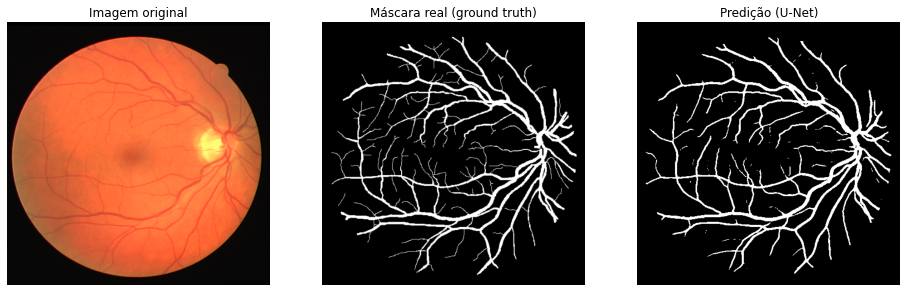

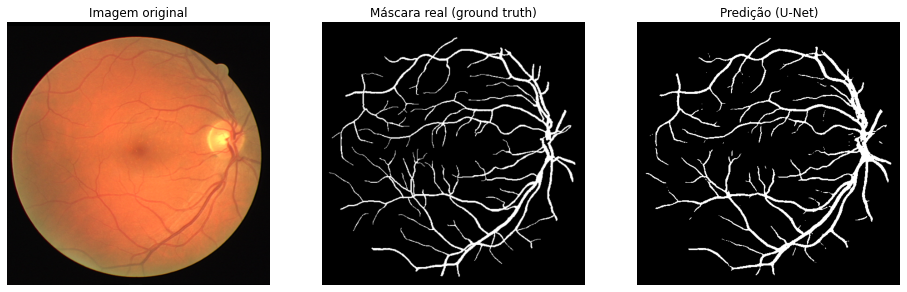

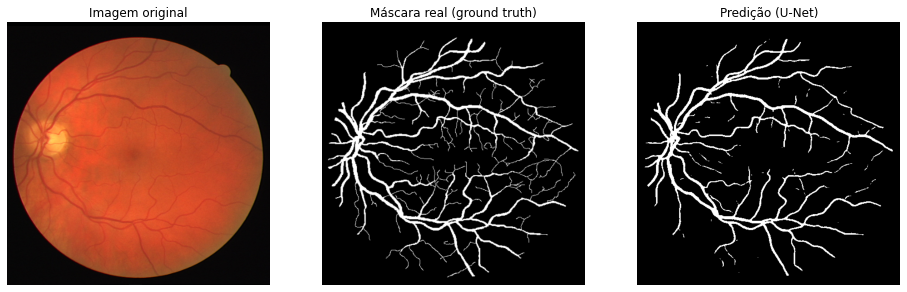

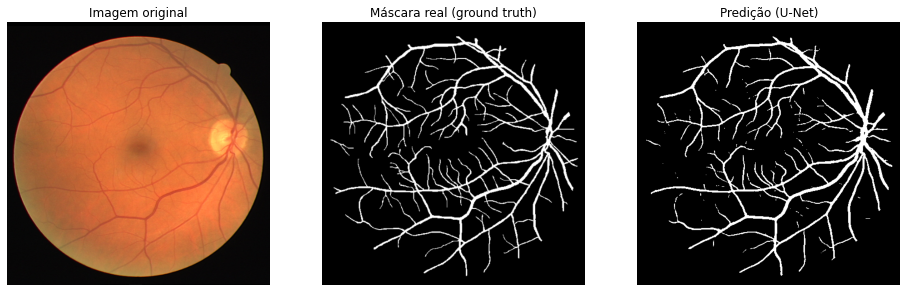

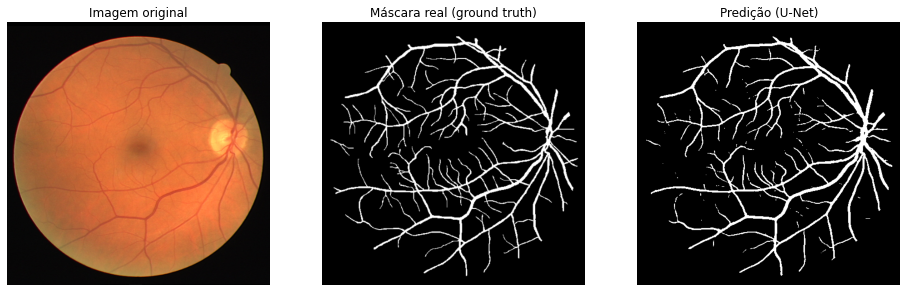

In [ ]:
lista_teste = np.random.choice(len(test_imgs), 5)
#print(lista_teste)
for id_img in lista_teste:
  img, img_original = ler_img(test_imgs[id_img])
  mask, mask_original = ler_mascara(test_masks[id_img])
  predicao = segmenta_img(img, modelo_teste)

  fig = plt.figure(figsize=(16, 8))
  fig.add_subplot(1,3,1)  
  plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title("Imagem original")

  plt.subplot(1,3,2)
  plt.imshow(mask_original, cmap="gray")
  plt.axis("off")
  plt.title("Máscara real (ground truth)") 
  
  plt.subplot(1,3,3)  
  plt.imshow(predicao, cmap="gray")
  plt.axis("off")
  plt.title("Predição (U-Net)")   

(512, 512, 3)


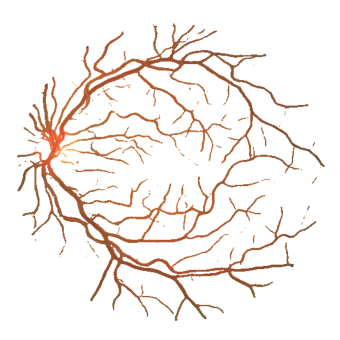

In [ ]:
id_img = 0
img, img_original = ler_img(test_imgs[id_img])
mask, mask_original = ler_mascara(test_masks[id_img])
predicao = segmenta_img(img, modelo_teste)
print(img.shape)

altura, largura = img.shape[:2]
fundo_branco = 255 * np.ones((altura, largura, 3), dtype='uint8')
img_final = img_original.copy()
img_final[predicao == 0] = fundo_branco[predicao == 0]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.axis('off');

# Avaliação

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import MeanIoU

In [ ]:
id_img = 0
img, img_original = ler_img(test_imgs[id_img])
mask, mask_original = ler_mascara(test_masks[id_img])
predicao = segmenta_img(img, modelo_teste)

In [ ]:
mask.shape, predicao.shape

((512, 512), (512, 512))

In [ ]:
pred_ = predicao.flatten()
mask_ = mask.flatten()
pred_.shape, mask_.shape

((262144,), (262144,))

In [ ]:
# IoU
iou_resultado = MeanIoU(num_classes = 2)
iou_resultado.update_state(mask, predicao)
valor_iou = iou_resultado.result().numpy()

In [ ]:
mask_, np.unique(mask_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0, 1], dtype=int32), array([248210,  13934])))

In [ ]:
pred_, np.unique(pred_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0, 1], dtype=int32), array([235289,  26855])))

In [ ]:
valor_acc = accuracy_score(mask_, pred_)

IoU:  0.70931387
Accuracy:  0.9448585510253906


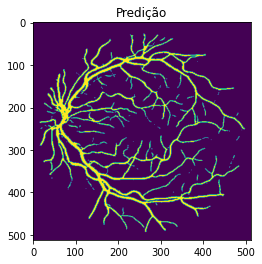

In [ ]:
plt.imshow(predicao)
plt.title('Predição')
print('IoU: ', valor_iou)
print('Accuracy: ', valor_acc)

In [ ]:
lista_scores = []
for x, y in tqdm(zip(test_imgs, test_masks), total=len(test_imgs)):
    nome = x.split("/")[-1].split(".")[0]

    img, img_original = ler_img(x)
    mask, mask_original = ler_mascara(y)
    predicao = segmenta_img(img, modelo_teste) 
    
    mask_ = mask.flatten()
    pred_ = predicao.flatten()

    IoU_resultado = MeanIoU(num_classes=2)  
    IoU_resultado.update_state(mask, predicao) 
    valor_iou = IoU_resultado.result().numpy() 
    
    valor_acc = accuracy_score(mask_, pred_)
    
    lista_scores.append([nome, valor_iou, valor_acc])

medias_score = [s[1:] for s in lista_scores]  
medias_score = np.mean(medias_score, axis=0)
print(f"\nMédia do IoU: {medias_score[0]:0.5f}") 
print(f"Média do Accuracy: {medias_score[1]:0.5f}")

100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Média do IoU: 0.75586
Média do Accuracy: 0.96081


In [ ]:
lista_scores

[['01_test', 0.70931387, 0.9448585510253906],
 ['02_test', 0.77852297, 0.9581680297851562],
 ['03_test', 0.76822853, 0.965057373046875],
 ['04_test', 0.7915313, 0.9659347534179688],
 ['05_test', 0.80066514, 0.969879150390625],
 ['06_test', 0.7797135, 0.96405029296875],
 ['07_test', 0.7790552, 0.9654045104980469],
 ['08_test', 0.7672547, 0.9659957885742188],
 ['09_test', 0.76392186, 0.9669342041015625],
 ['10_test', 0.7655168, 0.9652328491210938],
 ['11_test', 0.75088847, 0.9592971801757812],
 ['12_test', 0.7602062, 0.9624481201171875],
 ['13_test', 0.7793837, 0.9634437561035156],
 ['14_test', 0.73756206, 0.9575080871582031],
 ['15_test', 0.72691786, 0.961181640625],
 ['16_test', 0.7452074, 0.9564208984375],
 ['17_test', 0.74199, 0.9587631225585938],
 ['18_test', 0.72359335, 0.9541549682617188],
 ['19_test', 0.7254714, 0.9537010192871094],
 ['20_test', 0.7222345, 0.9578018188476562]]